## Imports

In [2]:
#pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import json
import cv2
import matplotlib.patches as patches
import albumentations as alb

## Loading files

In [8]:
DATA_PATH = "/mnt/sds-hd/sd22a004/guest/data_preprocessed/data_coco/"
PREDICTIONS_PATH = "/mnt/sds-hd/sd22a004/guest/predictions/"
SIDE_NUM = {'l': '02', 'r': '03'}

f = open(os.path.join(PREDICTIONS_PATH, 'predictions_stereo_100epochs_fold_1.json'), 'r')
json_decode = json.load(f)

filenames = json_decode['filenames']
annotations_gt = json_decode['labels']
predictions = json_decode['predictions']

## Defining helper functions

In [9]:
def extract_info(index):
    file_args = filenames[idx].split()
    annos_gt = annotations_gt[idx]
    annos_pred = predictions[idx]
    return file_args, annos_gt, annos_pred

def load_image(file_args):
    image_path = os.path.join(DATA_PATH, file_args[0], f'image_{SIDE_NUM[file_args[2]]}', 'images', file_args[1] + '.png')
    img = cv2.imread(image_path)
    return img

def resize_boxes(original_image, annos_gt, annos_pred):
    # Calculate Bounding boxes back to original size
    original_height, original_width, channels = original_image.shape
    img_small = cv2.resize(original_image, (256, 256))

    aug = alb.Compose([alb.Resize(height=original_height, width=original_width)], bbox_params = alb.BboxParams(format = 'pascal_voc', label_fields = ["class_labels"]))

    augmented_gt = aug(image=np.asarray(img_small), bboxes=annos_gt['boxes'], class_labels=annos_gt['labels'])
    annos_gt = {'boxes': augmented_gt['bboxes'], 'labels': augmented_gt['class_labels']}
    augmented_pred = aug(image=np.asarray(img_small), bboxes=annos_pred['boxes'], class_labels=annos_pred['labels'])
    annos_pred = {'boxes': augmented_pred['bboxes'], 'labels': augmented_pred['class_labels']}
    
    return annos_gt, annos_pred

## Show the images

---------------------------------06_03_000131---------------------------------


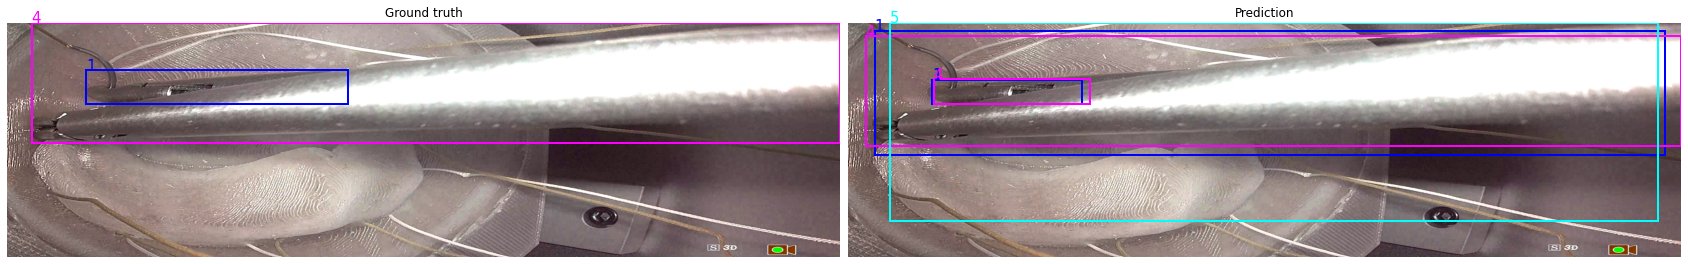

---------------------------------09_02_000044---------------------------------


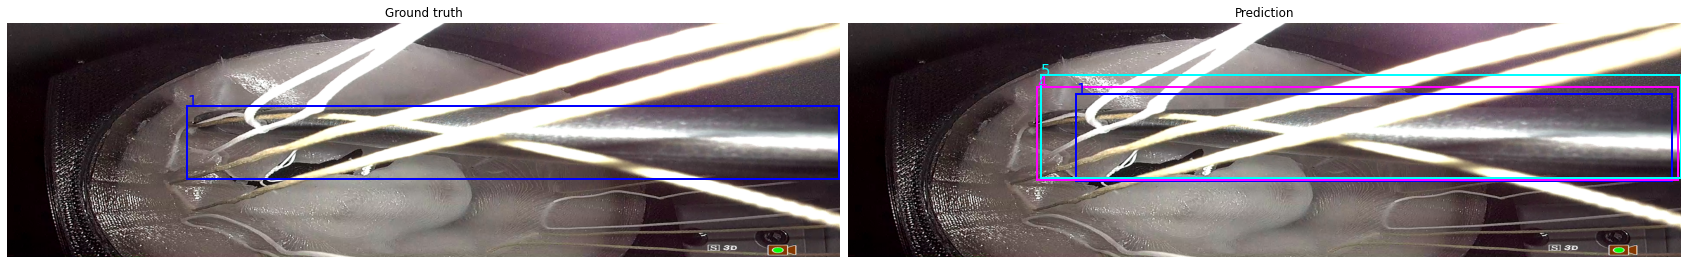

---------------------------------06_02_000149---------------------------------


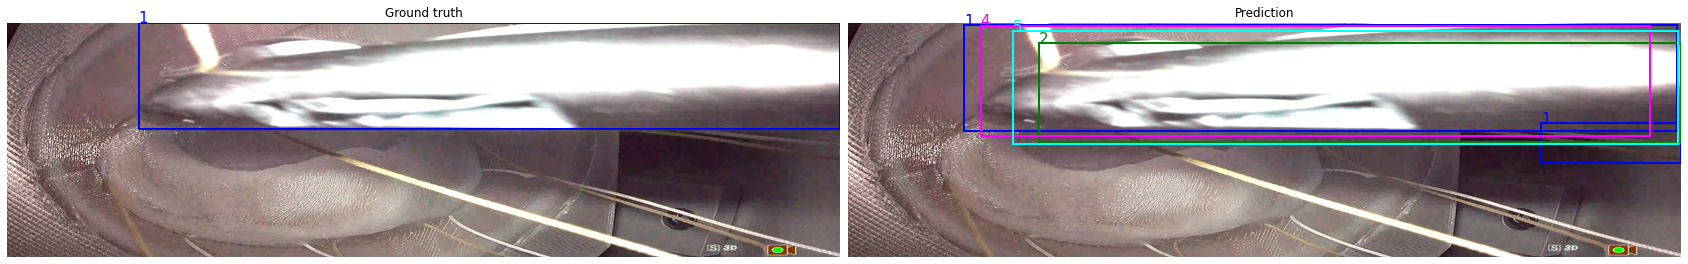

In [10]:
%matplotlib inline
COLORS = ['red', 'blue', 'green', 'yellow', 'magenta', 'cyan', 'orange']


for idx in [31, 231, 24]:
    file_args, annos_gt, annos_pred = extract_info(idx)
    print(f"---------------------------------{file_args[1]}---------------------------------")
    img = load_image(file_args)
    annos_gt, annos_pred = resize_boxes(img, annos_gt, annos_pred)
    
    fig = plt.figure(figsize=(30, 15))

    # Show image with ground truth boxes
    ax = plt.subplot(1, 2, 1)
    for box, label in zip(annos_gt['boxes'], annos_gt['labels']):
        bb = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor=COLORS[label], facecolor="none")
        ax.add_patch(bb)
        plt.text(box[0], box[1], label, fontsize=15, color=COLORS[label])   
        ax.add_patch(bb)

    ax.imshow(img)
    plt.axis('off')
    plt.title('Ground truth')

    # Show image with predictions
    ax = plt.subplot(1, 2, 2)
    for box, label in zip(annos_pred['boxes'], annos_pred['labels']):
        bb = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor=COLORS[int(label)], facecolor="none")
        ax.add_patch(bb)
        plt.text(box[0], box[1], int(label), fontsize=15, color=COLORS[int(label)])   
        ax.add_patch(bb)

    ax.imshow(img)
    plt.axis('off')
    plt.title('Prediction')
    plt.subplots_adjust(wspace=0.01)
    plt.show()
    plt.close(fig)